In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [40]:
df = pd.read_csv('tmdb_5000_movies.csv', usecols=['overview', 'title', 'vote_average'])
df.head()

,overview,title,vote_average
0,"In the 22nd century, a paraplegic Marine is di...",Avatar,7.2
1,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,6.9
2,A cryptic message from Bond’s past sends him o...,Spectre,6.3
3,Following the death of District Attorney Harve...,The Dark Knight Rises,7.6
4,"John Carter is a war-weary, former military ca...",John Carter,6.1


In [41]:
df = df.dropna(axis=0, how='any')

In [42]:
df["label"] = (df.vote_average >= 7).astype(int)
df = df[["overview", "label"]]
df

,overview,label
0,"In the 22nd century, a paraplegic Marine is di...",1
1,"Captain Barbossa, long believed to be dead, ha...",0
2,A cryptic message from Bond’s past sends him o...,0
3,Following the death of District Attorney Harve...,1
4,"John Carter is a war-weary, former military ca...",0
...,...,...
4798,El Mariachi just wants to play his guitar and ...,0
4799,A newlywed couple's honeymoon is upended by th...,0
4800,"""Signed, Sealed, Delivered"" introduces a dedic...",1
4801,When ambitious New York attorney Sam is sent t...,0


In [43]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [44]:
def df_to_dataset(dataframe, shuffle=True, batch_size=128):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df["overview"]
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [45]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# LSTM

In [46]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [47]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'and', 'of', 'in', 'his', 'is',
       'with', 'her', 'he', 'for', 'an', 'on', 'that', 'their', 'as',
       'when'], dtype='<U15')

In [48]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [50]:
model.evaluate(train_data)
model.evaluate(valid_data)

4/4 [==============================] - 0s 29ms/step - loss: 0.6947 - accuracy: 0.3208


[0.6946846842765808, 0.32083332538604736]

In [51]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
30/30 [==============================] - 9s 98ms/step - loss: 0.6099 - accuracy: 0.7792 - val_loss: 0.5334 - val_accuracy: 0.7917
Epoch 2/10
30/30 [==============================] - 3s 92ms/step - loss: 0.5188 - accuracy: 0.7956 - val_loss: 0.5179 - val_accuracy: 0.7917
Epoch 3/10
30/30 [==============================] - 3s 99ms/step - loss: 0.5145 - accuracy: 0.7958 - val_loss: 0.5118 - val_accuracy: 0.7917
Epoch 4/10
30/30 [==============================] - 3s 97ms/step - loss: 0.4985 - accuracy: 0.7958 - val_loss: 0.5025 - val_accuracy: 0.7917
Epoch 5/10
30/30 [==============================] - 3s 109ms/step - loss: 0.4543 - accuracy: 0.7958 - val_loss: 0.4979 - val_accuracy: 0.7896
Epoch 6/10
30/30 [==============================] - 3s 104ms/step - loss: 0.4041 - accuracy: 0.8234 - val_loss: 0.5083 - val_accuracy: 0.7875
Epoch 7/10
30/30 [==============================] - 3s 116ms/step - loss: 0.3554 - accuracy: 0.8464 - val_loss: 0.5594 - val_accuracy: 0.7854
Epoch 8/10

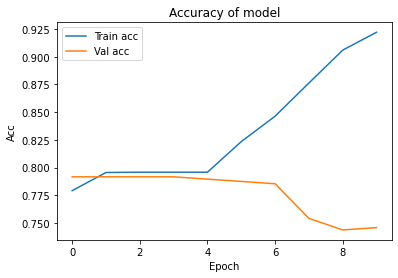

In [52]:
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Accuracy of model')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()

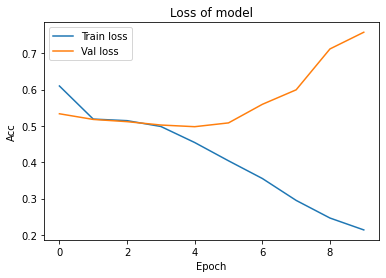

In [54]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Loss of model')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [53]:
model.evaluate(test_data)

4/4 [==============================] - 0s 49ms/step - loss: 0.8137 - accuracy: 0.7271


[0.8137064576148987, 0.7270833253860474]